In [50]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import pandas as pd 

한국석유공사 오피넷 / 국제 유가 / 원유
y : 내일의 Dubai 유가 예측
x : 과거 7일의 Dubai, Brent, WTI 데이터
모델 : rnn

In [51]:
df = pd.read_csv('./datasets/oil_price.csv', encoding='CP949')
df.shape

(183, 4)

In [52]:
df.head()

,기간,Dubai,Brent,WTI
0,19년01월02일,51.86,54.91,46.54
1,19년01월03일,53.20,55.95,47.09
2,19년01월04일,55.59,57.06,47.96
3,19년01월07일,56.79,57.33,48.52
4,19년01월08일,56.18,58.72,49.78


In [53]:
df.isna().sum()

기간       0
Dubai    0
Brent    0
WTI      0
dtype: int64

In [54]:
df = df.set_index('기간')
df.head()

,Dubai,Brent,WTI
기간,,,
19년01월02일,51.86,54.91,46.54
19년01월03일,53.20,55.95,47.09
19년01월04일,55.59,57.06,47.96
19년01월07일,56.79,57.33,48.52
19년01월08일,56.18,58.72,49.78


In [55]:
df.columns

Index(['Dubai', 'Brent', 'WTI'], dtype='object')

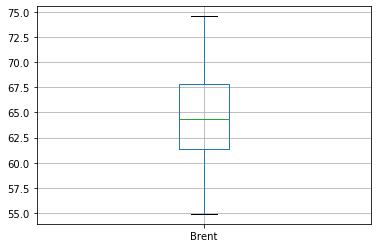

In [56]:
df.boxplot()

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 19년01월02일 to 19년09월16일
Data columns (total 3 columns):
Dubai    183 non-null object
Brent    183 non-null float64
WTI      183 non-null object
dtypes: float64(1), object(2)
memory usage: 5.7+ KB


In [58]:
# -를 평균으로 변경
##x
df['Dubai'] = df['Dubai'].replace('-', np.NAN)
df['WTI'] = df['WTI'].replace('-', np.NAN)
df.isna().sum()

Dubai    7
Brent    0
WTI      5
dtype: int64

In [59]:
#mean_dubai = df['Dubai'].dropna().mean()
#df['Dubai'] = df['Dubai'].fillna(mean_dubai)
df = df.dropna()
df.shape

(171, 3)

In [61]:
df.head()

,Dubai,Brent,WTI
기간,,,
19년01월02일,51.86,54.91,46.54
19년01월03일,53.20,55.95,47.09
19년01월04일,55.59,57.06,47.96
19년01월07일,56.79,57.33,48.52
19년01월08일,56.18,58.72,49.78


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171 entries, 19년01월02일 to 19년09월16일
Data columns (total 3 columns):
Dubai    171 non-null object
Brent    171 non-null float64
WTI      171 non-null object
dtypes: float64(1), object(2)
memory usage: 5.3+ KB


In [64]:
df = df.astype(np.float32)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171 entries, 19년01월02일 to 19년09월16일
Data columns (total 3 columns):
Dubai    171 non-null float32
Brent    171 non-null float32
WTI      171 non-null float32
dtypes: float32(3)
memory usage: 3.3+ KB


In [66]:
df.columns

Index(['Dubai', 'Brent', 'WTI'], dtype='object')

In [71]:
df_rol = df.rolling(window=7).mean()

In [72]:
df_rol.columns = ['Dubai_rol', 'Brent_rol', 'WTI_rol']

In [75]:
df_con = pd.concat((df, df_rol), axis=1).dropna()
df_con.head()

,Dubai,Brent,WTI,Dubai_rol,Brent_rol,WTI_rol
기간,,,,,,
19년01월10일,59.599998,61.680000,52.590000,55.898572,58.155715,49.262857
19년01월11일,61.160000,60.480000,51.590000,57.227143,58.951429,49.984286
19년01월14일,58.919998,58.990002,50.509998,58.044285,59.385715,50.472857
19년01월15일,58.630001,60.639999,52.110001,58.478571,59.897143,51.065714
19년01월16일,60.150002,61.320000,52.310001,58.958571,60.467143,51.607143


In [76]:
df_con.shape, len(df_con)

((165, 6), 165)

In [78]:
x_T = 7
y_T = 1
# X (285, 5, 12), y (285, 5)
x_list = []
y_list = []
for i in range(len(df_con) - (x_T + y_T) + 1):  
    x = df_con.iloc[i : i+x_T]
    y = df_con.iloc[i+x_T : i+x_T+y_T]['Dubai']
    x_list.append(x)
    y_list.append(y)
len(x_list), len(y_list)

(158, 158)

In [79]:
X = np.stack(x_list, 0).astype(np.float32)
y = np.stack(y_list, 0).astype(np.float32)
type(X), X.shape, y.shape, X.dtype, y.dtype

(numpy.ndarray, (158, 7, 6), (158, 1), dtype('float32'), dtype('float32'))

In [80]:
np.max(X), np.max(y)

(74.57, 74.46)

In [81]:
from sklearn.preprocessing import MinMaxScaler
X_2d = X.reshape([-1, 12]) # 3d > 2d
y_2d = y.reshape([-1, 1]) # 특징 5개가 아니고 , 특징 1개 이므로 
scaler_x = MinMaxScaler().fit(X_2d)
scaler_y = MinMaxScaler().fit(y_2d)
xn = scaler_x.transform(X_2d)
yn = scaler_y.transform(y_2d)
xn = xn.reshape(X.shape) # 2d > 3d
yn = yn.reshape(y.shape)
xn.shape, yn.shape,  np.min(xn), np.max(xn), np.min(yn), np.max(yn)

((158, 7, 6), (158, 1), 0.0, 1.0000002, 0.0, 1.0)

In [83]:
import tensorflow.contrib.slim as slim
tf.reset_default_graph()
cell_enc = tf.nn.rnn_cell.GRUCell(100, name='enc')
cell_dec = tf.nn.rnn_cell.GRUCell(100, name='dec')
net = slim.conv1d(xn, num_outputs=10, kernel_size=3)
outputs, last_state = tf.nn.dynamic_rnn(cell_enc, net, dtype=tf.float32)
zero = tf.zeros([len(xn), y_T, 1]) # x와 y 의 시퀀스가 다를 때 
context_vector = last_state # 모든 정보가 이 안에 있습니다
outputs, last_state = tf.nn.dynamic_rnn(cell_dec,zero,initial_state=context_vector)
h = slim.fully_connected(outputs, 1)
h = tf.squeeze(h, axis=-1) #맨 뒤쪽 차원을 제거해라 
cost = tf.reduce_mean((yn - h)**2)
train = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [85]:
for i in range(1000):
    _, c = sess.run([train, cost])    
    if i%100 == 0: print(i, c)
print(i, c)

0 0.004053916
100 0.0039198226
200 0.0037980797
300 0.0036869196
400 0.0035770275
500 0.0034185227
600 0.0037037993
700 0.0039468845
800 0.0037234628
900 0.0036954428
999 0.0035966241


In [91]:
from sklearn.metrics import r2_score
predict = sess.run(h) # 미래 5일 예측 종가
for i in range(y_T):
    print(i+1, '일 후', predict[-1:, [i]], '값으로', r2_score(yn[:, [i]], predict[:, [i]]))

1 일 후 [[0.17576481]] 값으로 0.9394592595848573


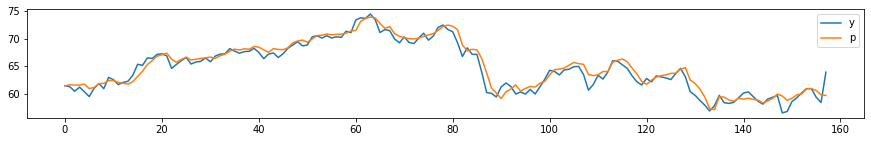

In [87]:
plt.figure(figsize=(15,2))
plt.plot(scaler_y.inverse_transform(yn[:, [0]]), label='y')
plt.plot(scaler_y.inverse_transform(predict[:, [0]]), label='p')
plt.legend()